In [1]:

from PIL import Image

import torch

import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict

def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)
    _ = model.eval()
    return model

/home/arel/.local/share/virtualenvs/clother-Pgv20BEv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arel/Devel/clother/gsa/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [2]:
from GroundingDINO.groundingdino.util.utils import get_phrases_from_posmap


def get_grounding_output(model, image, caption, box_threshold, text_threshold, with_logits=True, device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)

    return boxes_filt, pred_phrases

In [3]:
import os
from matplotlib import pyplot as plt
import numpy as np


def extract_foreground_and_background(affix, output_dir, image, mask_list):
    value = 0

    mask_img = torch.zeros(mask_list.shape[-2:])
    for idx, mask in enumerate(mask_list):
        mask_img[mask.cpu().numpy()[0] == True] = value + idx + 1

    maski = mask_img.numpy()

    negative_img = ( np.tile(maski[:,:,np.newaxis],(1,1,3)).astype(int) ) * 255
    positive_img = ( np.logical_not(negative_img) ) * 255

    foreground_only = image & negative_img 

    plt.figure(figsize=(10,10))
    plt.imshow(foreground_only)
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'{affix}_foreground.jpg'), bbox_inches="tight", dpi=300, pad_inches=0.0)

    background_only = image & positive_img 

    plt.figure(figsize=(10,10))
    plt.imshow(background_only)
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'{affix}_background.jpg'), bbox_inches="tight", dpi=300, pad_inches=0.0)

    return ( maski, positive_img, foreground_only, background_only )

In [4]:
import cv2

from segment_anything import (
    sam_model_registry,
    SamPredictor
)

def extract(
    model,
    output_dir,
    name,
    image_path,
    text_prompt,
    box_threshold,
    text_threshold,
    sam_version,
    sam_checkpoint
):
    device = "cpu"

    image_pil, image = load_image(image_path)
    image_pil.resize((512, 512))
    image_pil.save(os.path.join(output_dir, f"{name}_raw_image.jpg"))

    boxes_filt, pred_phrases = get_grounding_output(
        model, image, text_prompt, box_threshold, text_threshold, device=device
    )

    predictor = SamPredictor(sam_model_registry[sam_version](checkpoint=sam_checkpoint).to(device))
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    size = image_pil.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()
    transformed_boxes = predictor.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(device)

    masks, _, _ = predictor.predict_torch(
        point_coords = None,
        point_labels = None,
        boxes = transformed_boxes.to(device),
        multimask_output = False,
    )

    return (image_pil,) + extract_foreground_and_background(name, output_dir, image, masks)

In [5]:
def extract_foreground_and_background(affix, output_dir, image, mask_list):
    value = 0

    mask_img = torch.zeros(mask_list.shape[-2:])
    for idx, mask in enumerate(mask_list):
        mask_img[mask.cpu().numpy()[0] == True] = value + idx + 1

    maski = mask_img.numpy()

    negative_img = ( np.tile(maski[:,:,np.newaxis],(1,1,3)).astype(np.uint8) ) * 255
    
    if affix == "destination":
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20)) 
        negative_img = cv2.dilate(negative_img, kernel)

    positive_img = ( np.logical_not(negative_img) ) * 255

    plt.figure(figsize=(10,10))
    plt.imshow(negative_img)
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'{affix}_foreground_mask.jpg'), bbox_inches="tight", dpi=300, pad_inches=0.0)

    plt.figure(figsize=(10,10))
    plt.imshow(image & negative_img)
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'{affix}_foreground.jpg'), bbox_inches="tight", dpi=300, pad_inches=0.0)

    plt.figure(figsize=(10,10))
    plt.imshow(positive_img)
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'{affix}_background_mask.jpg'), bbox_inches="tight", dpi=300, pad_inches=0.0)

    plt.figure(figsize=(10,10))
    plt.imshow(image & positive_img)
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'{affix}_background.jpg'), bbox_inches="tight", dpi=300, pad_inches=0.0)

    return ( maski, positive_img, negative_img, positive_img )

In [6]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

/home/arel/.local/share/virtualenvs/clother-Pgv20BEv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Reading ../inputs/jog.jpg
final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/home/arel/.local/share/virtualenvs/clother-Pgv20BEv/lib/python3.12/site-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/arel/.local/share/virtualenvs/clother-Pgv20BEv/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/arel/.local/share/virtualenvs/clother-Pgv20BEv/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/arel/.local/share/virtualenvs/clother-Pgv20BEv/lib/pyt

(<PIL.Image.Image image mode=RGB size=5355x7612>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
        

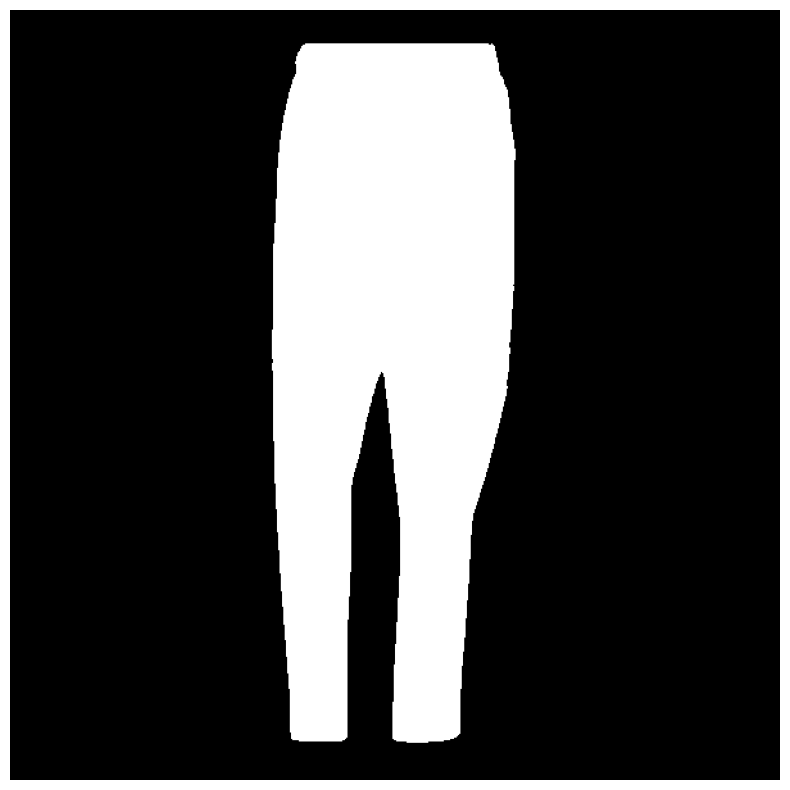

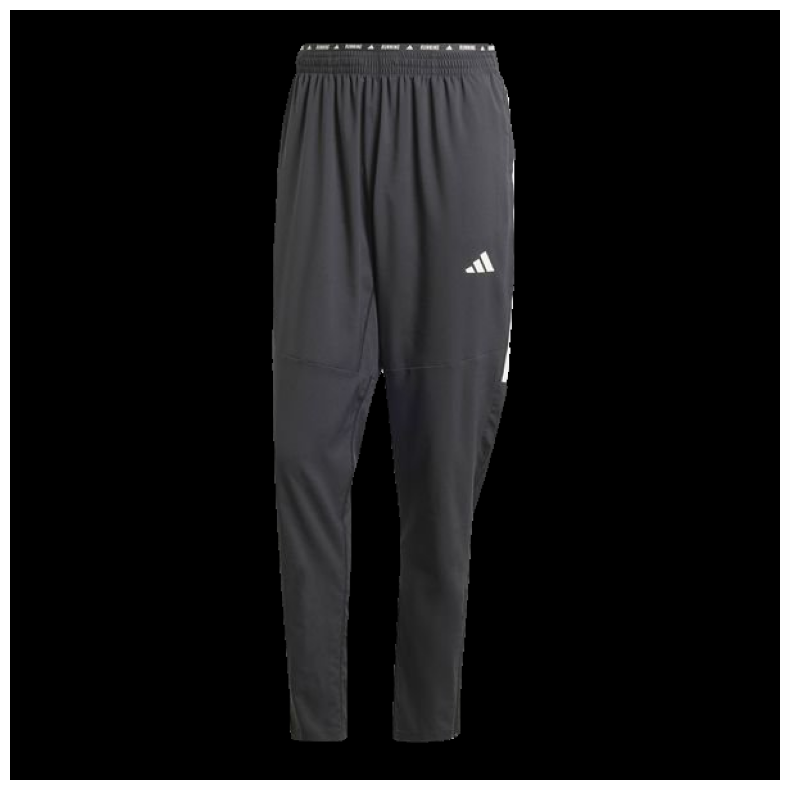

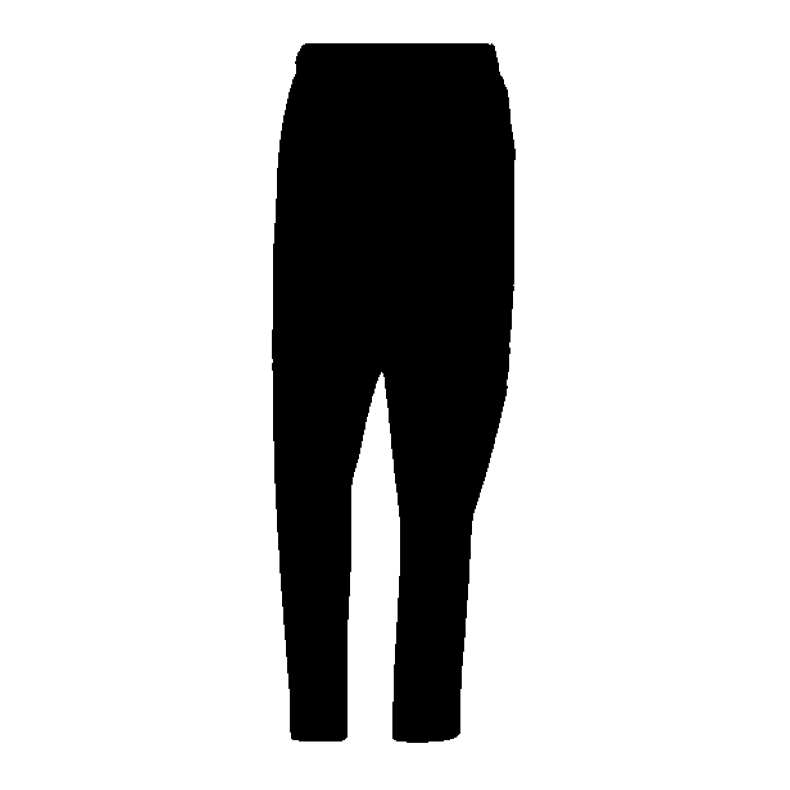

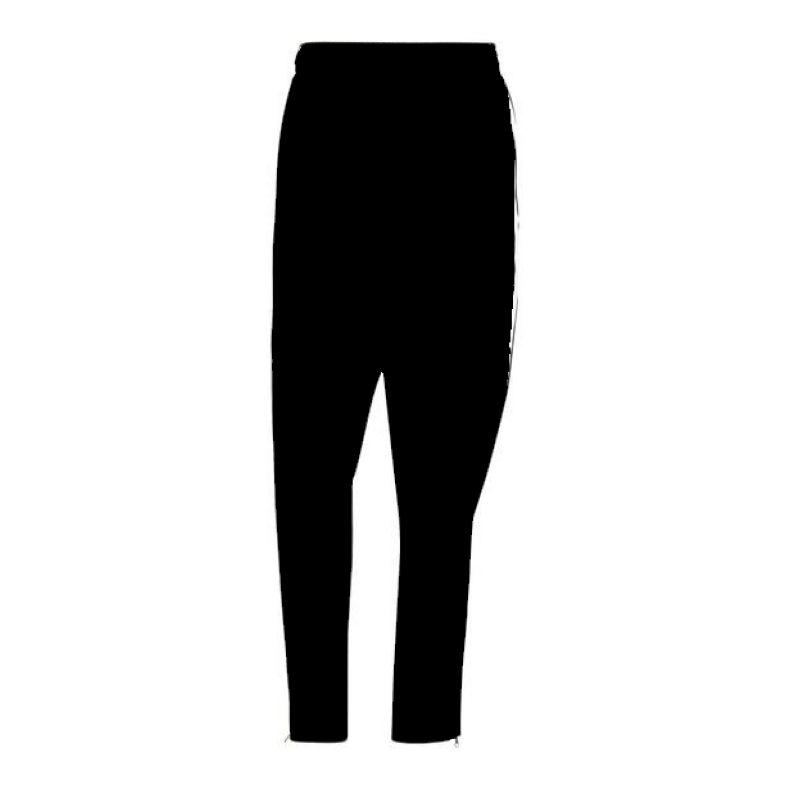

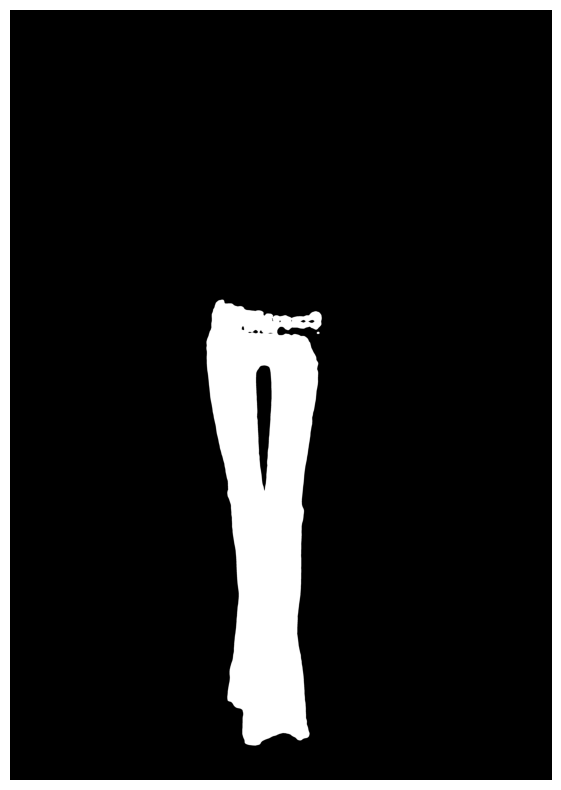

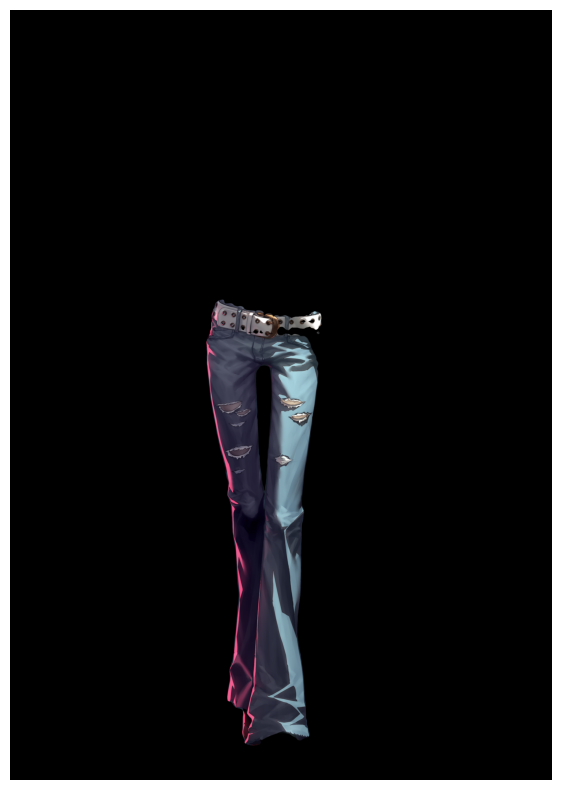

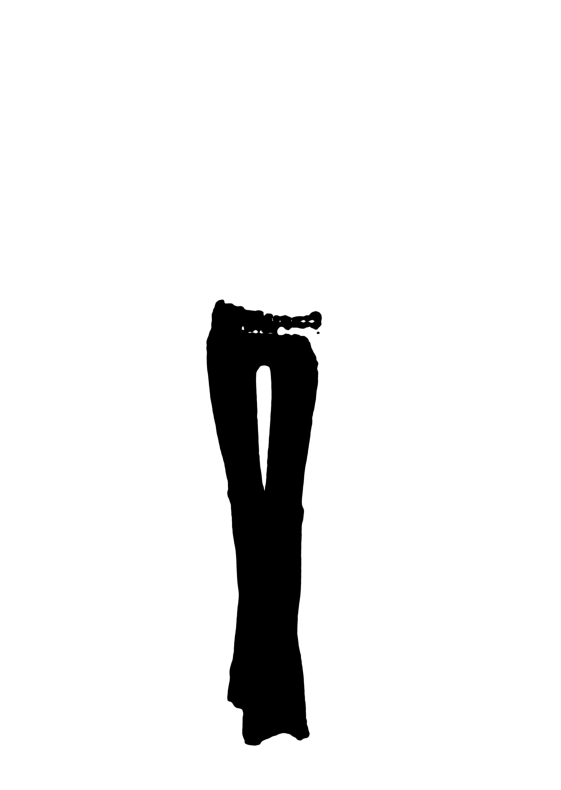

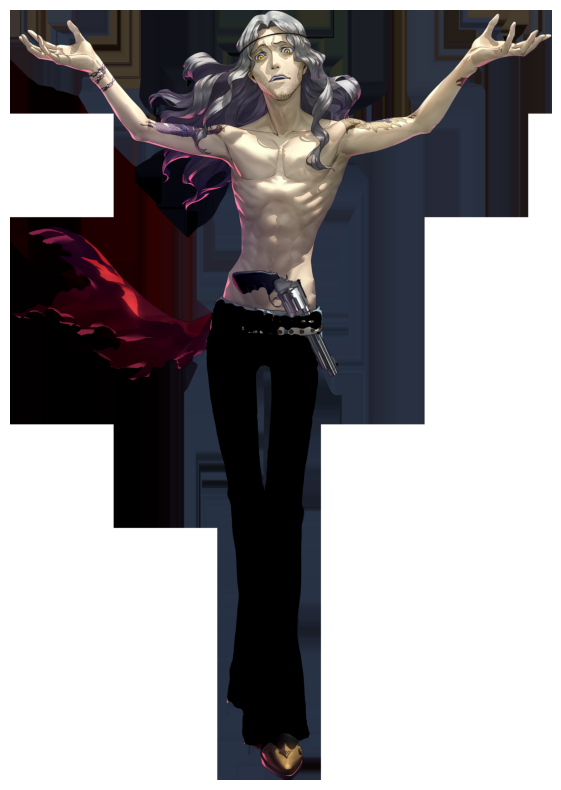

In [7]:
config_file = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
grounded_checkpoint = "groundingdino_swint_ogc.pth" 
sam_version = "vit_h"
sam_checkpoint = "sam_vit_h_4b8939.pth"
image_path_foreground = "../inputs/jog.jpg"
image_path_background = "../inputs/takaya.png"
foreground_prompt = "pants" 
background_prompt = "pant"
output_dir = "../illus_pants"
box_threshold = 0.3
text_threshold = 0.25
device = "cpu"

os.makedirs(output_dir, exist_ok=True)
print(f"Reading {image_path_foreground}")
model = load_model(config_file, grounded_checkpoint, device=device)
extract(
    model,
    output_dir,
    "source",
    image_path_foreground,
    foreground_prompt,
    box_threshold,
    text_threshold,
    sam_version,
    sam_checkpoint
)
extract(
    model,
    output_dir,
    "destination",
    image_path_background,
    background_prompt,
    box_threshold,
    text_threshold,
    sam_version,
    sam_checkpoint
)
